In [1]:
from shearletNN.shearlets import getcomplexshearlets2D
from shearletNN.shearlet_utils import (
    frequency_shearlet_transform,
    spatial_shearlet_transform,
    ShearletTransformLoader,
    shifted_frequency_shearlet_transform,
    shifted_spatial_shearlet_transform,
    hartley_shearlet_transform,
)
from shearletNN.complex_resnet import (
    complex_resnet18,
    complex_resnet34,
    complex_resnet50,
)

from shearletNN.layers import CGELU, CReLU

import torch
import torchvision
from torchvision.transforms import v2
from torchvision import transforms

import gc
from tqdm import tqdm
import matplotlib.pyplot as plt


patch_size = 32
image_size = 64

rows, cols = image_size, image_size


shearlets, shearletIdxs, RMS, dualFrameWeights = getcomplexshearlets2D(
    rows,
    cols,
    1,  # scales per octave
    3,  # shear level (something like O(log of directions))
    1,  # octaves
    0.5,  # alpha
    wavelet_eff_support=image_size,
    gaussian_eff_support=image_size,
)

shearlets = torch.tensor(shearlets).permute(2, 0, 1).type(torch.complex64).to(0)[:]

In [2]:
def train(model, optimizer, loader, accumulate=1):
    model.train()
    loss = torch.nn.CrossEntropyLoss()

    for i, (X, y) in tqdm(enumerate(loader)):
        out = model(X.to(0))
        optimizer.zero_grad()
        l = loss(out, y.to(0)) / accumulate
        l.backward()
        if i % accumulate == (accumulate - 1):
            optimizer.step()


def accuracy(output, target, topk=(1,)):
    output = output.to(torch.device("cpu"))
    target = target.to(torch.device("cpu"))
    maxk = max(topk)
    batch_size = target.shape[0]

    _, idx = output.sort(dim=1, descending=True)
    pred = idx.narrow(1, 0, maxk).t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(dim=0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def epoch_accuracy(loader_s, student):
    student.eval()

    out_epoch_s = [
        accuracy(student(L.to(0)), y)[0].detach().cpu().item() for L, y in loader_s
    ]

    student.train()

    return sum(out_epoch_s) / len(out_epoch_s)


def test(network, test_loader):
    network.eval().to(0)
    test_loss = 0
    correct = 0
    total = 0
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(0))
            test_loss += torch.nn.CrossEntropyLoss()(output, target.to(0)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += target.shape[0]
        test_loss /= total
        test_losses.append(test_loss)
        print(
            "\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss, correct, total, 100.0 * correct / total
            )
        )


class IndexSubsetDataset:
    def __init__(self, ds, inds):
        self.ds = ds
        self.inds = inds

    def __iter__(self):
        for i in range(len(self.inds)):
            yield self[i]

    def __getitem__(self, i):
        return self.ds[self.inds[i]]

    def __len__(self):
        return len(self.inds)


def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children

In [3]:
def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear) or isinstance(mod, torch.nn.Conv2d):
            linear_children.append((name, module))
    return linear_children


def getattrrecur(mod, s):
    s = s.split(".")
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split(".")
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)


def spectral_normalize(model):
    for name, mod in linearleaves(model):
        setattrrecur(
            model,
            name,
            torch.nn.utils.parametrizations.spectral_norm(getattrrecur(mod, name)),
        )

    return model

In [4]:
def batch_cov_3d(points, mean):
    """
    for our purposes we want to batch the covariance along the channel dimension (originally 1) and compute it over the batch dimension (originally 0)

    we need a covariance matrix for each channel along the batch dimension, so of shape (C, 2, 2)

    Input: points \in (B, C, H, W, D)

    """
    points = points - mean
    points = points.permute(1, 0, 2, 3, 4)  # Channels first for the reshape
    C, B, H, W, D = points.size()
    N = B * H * W
    diffs = points.reshape(C * N, D)
    prods = torch.bmm(diffs.unsqueeze(2), diffs.unsqueeze(1)).reshape(C, N, D, D)
    bcov = prods.sum(dim=1) / N
    return bcov  # (C, D, D)


def loader_mean_cov(loader):
    total = 0
    mean = None
    cov = None

    for x, y in loader:
        total += 1
        if mean is None:
            mean = torch.stack((
                torch.mean(x.real, dim=(0, 2, 3), keepdim=True),
                torch.mean(x.imag, dim=(0, 2, 3), keepdim=True),
                ),
                -1
            )
        else:
            mean += torch.stack((
                torch.mean(x.real, dim=(0, 2, 3), keepdim=True),
                torch.mean(x.imag, dim=(0, 2, 3), keepdim=True),
                ),
                -1
            )
        if cov is None:
            cov = batch_cov_3d(torch.stack((x.real, x.imag), dim=-1), mean)

        else:
            cov = ( ( (total - 2) / (total - 1) ) * cov ) + ( (1 / total) * batch_cov_3d(torch.stack((x.real, x.imag), dim=-1), mean / total ) )

    return mean, cov


class Normalizer:
    def __init__(self, mean, cov, eps=1e-6):
        self.mean = mean
        self.cov = cov
        self.epsilon_matrix = torch.eye(2) * eps

        # Inv and sqrtm is done over 2 inner most dimension [..., M, M] so it should be [..., 2, 2] for us.
        # torch has no matrix square root, so we have
        L, Q = torch.linalg.eigh(
            torch.linalg.inv((self.cov + self.epsilon_matrix.unsqueeze(0).to(self.cov.device)).to(torch.float64))
        )  # low precision dtypes not supported
        # eigenvalues of positive semi-definite matrices are always real (and non-negative)
        diag = torch.diag_embed(L ** (0.5))
        self.inv_sqrt_var = Q @ diag @ Q.mH  # var^(-1/2), (C, 2, 2)

    def __call__(self, inputs):
        # Separate real and imag so I go from shape [...] to [..., 2]
        inputs = torch.stack((inputs.real, inputs.imag), -1)

        zero_mean = inputs - self.mean
        # (C, 2, 2) @ (B, H, W, C, 2, 1) -> (B, H, W, C, 2, 1)
        inputs_hat = torch.matmul(
            self.inv_sqrt_var.to(inputs.dtype), zero_mean.permute(0, 2, 3, 1, 4).unsqueeze(-1)
        )
        # Then I squeeze to remove the last shape so I go from [..., 2, 1] to [..., 2].
        # Use reshape and not squeeze in case I have 1 channel for example.
        squeeze_inputs_hat = torch.reshape(inputs_hat, shape=inputs_hat.shape[:-1]).permute(0, 3, 1, 2, 4)
        # Get complex data
        complex_inputs_hat = torch.complex(
            squeeze_inputs_hat[..., 0], squeeze_inputs_hat[..., 1]
        ).type(torch.complex64)

        return complex_inputs_hat

In [5]:
batch_size_train = 128

In [6]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def symlog(x, threshold=1):
    return torch.sign(x) * torch.log(1 + torch.abs(x / threshold))

def symsqrt(x):
    return torch.sign(x) * torch.sqrt(torch.abs(x))

def complex_symsqrt(x):
    real = x.real
    imag = x.imag

    return torch.complex(symsqrt(real), symsqrt(imag))

def complex_symlog(x, threshold=1):
    real = x.real
    imag = x.imag

    return torch.complex(symlog(real, threshold), symlog(imag, threshold))

def shearlet_transform(img):
    return complex_symsqrt(spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)


mean, cov = loader_mean_cov(tqdm(train_loader))

norm = Normalizer(mean, cov)

/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


391it [00:09, 39.28it/s]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/98 [00:00<?, ?it/s]

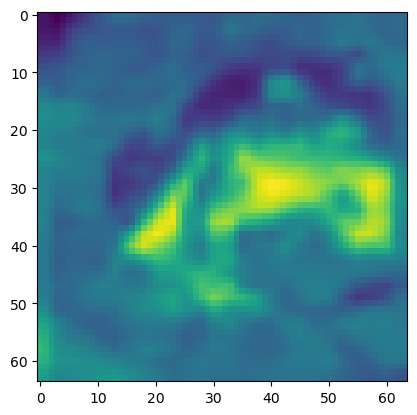

  0%|          | 0/98 [00:00<?, ?it/s]
0it [00:00, ?it/s]

tensor([-0.4072, -0.4087, -0.4133, -0.2793, -0.2764, -0.2757, -0.2769, -0.2806,
         0.4137,  0.4089, -0.4742, -0.4755, -0.4795, -0.1274, -0.1267, -0.1266,
        -0.1271, -0.1285,  0.4797,  0.4756,  0.1816,  0.1842,  0.1902,  0.4315,
         0.4242,  0.4219,  0.4243,  0.4316, -0.1881, -0.1829], device='cuda:0')
tensor([-0.0135, -0.0132, -0.0127, -2.9196, -2.8939, -2.8851, -2.8936, -2.9191,
         0.0143,  0.0138,  0.0207,  0.0217,  0.0234, -4.4454, -4.4077, -4.3948,
        -4.4075, -4.4452, -0.0195, -0.0198,  0.0249,  0.0256,  0.0272, -6.1644,
        -6.1116, -6.0935, -6.1113, -6.1638, -0.0250, -0.0249], device='cuda:0')
tensor([0.4854, 0.4854, 0.4854, 0.4905, 0.4905, 0.4905, 0.4905, 0.4905, 0.4854,
        0.4854, 0.4769, 0.4768, 0.4768, 0.4836, 0.4836, 0.4836, 0.4836, 0.4836,
        0.4768, 0.4768, 0.4786, 0.4786, 0.4786, 0.4846, 0.4846, 0.4846, 0.4846,
        0.4846, 0.4786, 0.4786], device='cuda:0')
tensor([0.4854, 0.4854, 0.4853, 0.4917, 0.4917, 0.4917, 0.4917, 0.4917

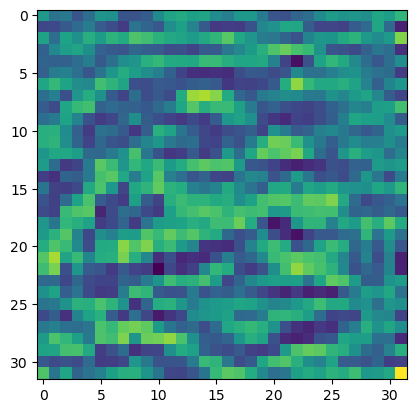

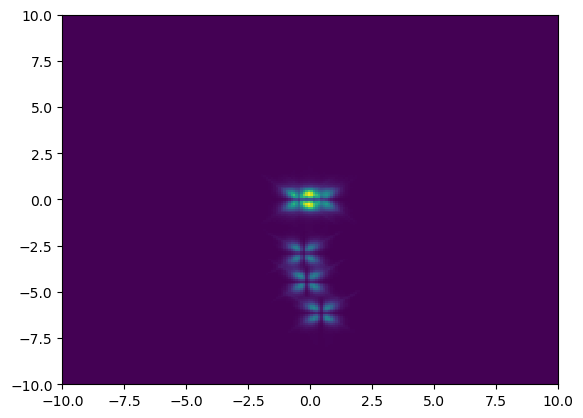

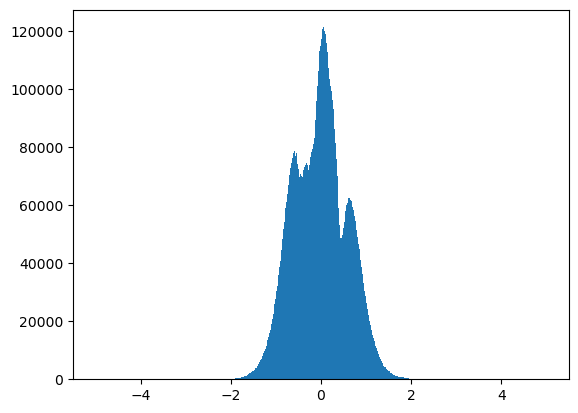

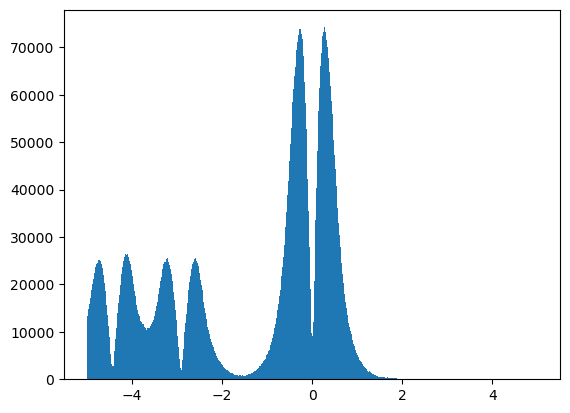

0it [00:02, ?it/s]

building model...


In [7]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=512, shuffle=False, num_workers=0
)

for x, y in tqdm(train_loader):
    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    break

shearlets = shearlets[:]


def shearlet_transform(img):

    return norm(complex_symsqrt(spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size)))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        512,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.real.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.real.max())
    print(x.imag.min())
    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    plt.hist2d(x.flatten().real.cpu().numpy(), x.flatten().imag.cpu().numpy(), bins=200, range=[[-10, 10], [-10, 10]])
    plt.show()
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()
    plt.hist(x.flatten().imag.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()
    break
print("building model...")


In [8]:
# if this does not achieve 61 percent then it is worse than a different layer for each input
# model = complex_freakformer_tiny_patch4_LS(
#     img_size=image_size, in_chans=shearlets.shape[0] * 3
# )
# 85% at the 64p resolution spatial, 75% at the 32p resolution, 79% at 32p compressed from 64
# not using the sqrt + symlog is worse
# using symlog only is better (81%)
# 71% at 16p

# on caltech 101 65% at 32p

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

shearlets = shearlets[:]


def shearlet_transform(img):

    return norm(complex_symsqrt(spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size)))


model = complex_resnet18(in_dim = shearlets.shape[0] * 3, complex=True)

with torch.no_grad():
    for param in model.parameters():
        if not ((param == 0).all() or (param == 1).all()):
            param.data /= 2 ** (0.5)
        if param.is_complex():
            param.data = param.data.type(torch.complex64)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


391it [00:36, 10.86it/s]


epoch 1


391it [00:36, 10.80it/s]


epoch 2


391it [00:36, 10.80it/s]


epoch 3


391it [00:34, 11.20it/s]


epoch 4


391it [00:34, 11.27it/s]


epoch 5


391it [00:36, 10.77it/s]


epoch 6


391it [00:35, 10.97it/s]


epoch 7


391it [00:35, 11.12it/s]


epoch 8


391it [00:36, 10.74it/s]


epoch 9


391it [00:36, 10.79it/s]


epoch 10


391it [00:34, 11.27it/s]


epoch 11


391it [00:36, 10.81it/s]


epoch 12


391it [00:36, 10.84it/s]


epoch 13


391it [00:35, 11.10it/s]


epoch 14


391it [00:36, 10.82it/s]


epoch 15


391it [00:36, 10.82it/s]


epoch 16


391it [00:36, 10.69it/s]


epoch 17


391it [00:36, 10.81it/s]


epoch 18


391it [00:35, 10.95it/s]


epoch 19


391it [00:35, 10.88it/s]


epoch 20


391it [00:37, 10.56it/s]


epoch 21


391it [00:35, 11.12it/s]


epoch 22


391it [00:35, 11.07it/s]


epoch 23


391it [00:35, 10.86it/s]


epoch 24


391it [00:34, 11.21it/s]


epoch 25


391it [00:35, 10.87it/s]


epoch 26


391it [00:35, 10.97it/s]


epoch 27


391it [00:34, 11.24it/s]


epoch 28


391it [00:35, 10.91it/s]


epoch 29


391it [00:36, 10.77it/s]


epoch 30


391it [00:35, 11.04it/s]


epoch 31


391it [00:36, 10.63it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 32


391it [00:36, 10.86it/s]


epoch 33


391it [00:34, 11.32it/s]


epoch 34


391it [00:35, 10.89it/s]


epoch 35


391it [00:36, 10.77it/s]


epoch 36


391it [00:49,  7.93it/s]


epoch 37


391it [00:51,  7.63it/s]


epoch 38


391it [00:52,  7.46it/s]


epoch 39


391it [00:53,  7.35it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 40


391it [00:52,  7.42it/s]


epoch 41


391it [00:51,  7.57it/s]


epoch 42


391it [00:51,  7.61it/s]


epoch 43


391it [00:53,  7.29it/s]


epoch 44


391it [00:53,  7.31it/s]


epoch 45


391it [00:52,  7.41it/s]


epoch 46


391it [00:52,  7.51it/s]


epoch 47


391it [00:53,  7.35it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 48


391it [00:52,  7.51it/s]


epoch 49


391it [00:53,  7.31it/s]


epoch 50


391it [00:52,  7.51it/s]


epoch 51


391it [00:54,  7.21it/s]


epoch 52


391it [00:54,  7.19it/s]


epoch 53


391it [00:54,  7.21it/s]


epoch 54


391it [00:54,  7.22it/s]


epoch 55


391it [00:54,  7.23it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 56


391it [00:52,  7.45it/s]


epoch 57


391it [00:54,  7.21it/s]


epoch 58


391it [00:55,  7.05it/s]


epoch 59


391it [00:52,  7.41it/s]


epoch 60


391it [00:51,  7.62it/s]


epoch 61


391it [00:52,  7.47it/s]


epoch 62


391it [00:53,  7.31it/s]


epoch 63


391it [00:52,  7.49it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 64


391it [00:52,  7.42it/s]


epoch 65


391it [00:53,  7.34it/s]


epoch 66


391it [00:52,  7.39it/s]


epoch 67


391it [00:52,  7.47it/s]


epoch 68


391it [00:54,  7.16it/s]


epoch 69


391it [00:53,  7.31it/s]


epoch 70


391it [00:54,  7.22it/s]


epoch 71


391it [00:53,  7.28it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 72


391it [00:52,  7.44it/s]


epoch 73


391it [00:55,  7.05it/s]


epoch 74


391it [00:53,  7.28it/s]


epoch 75


391it [00:51,  7.60it/s]


epoch 76


391it [00:52,  7.50it/s]


epoch 77


391it [00:51,  7.53it/s]


epoch 78


391it [00:53,  7.24it/s]


epoch 79


391it [00:51,  7.62it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 80


391it [00:52,  7.39it/s]


epoch 81


391it [00:53,  7.30it/s]


epoch 82


391it [00:53,  7.31it/s]


epoch 83


391it [00:53,  7.34it/s]


epoch 84


391it [00:53,  7.28it/s]


epoch 85


391it [00:53,  7.33it/s]


epoch 86


391it [00:53,  7.28it/s]


epoch 87


391it [00:40,  9.72it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 88


391it [00:31, 12.59it/s]


epoch 89


391it [00:29, 13.12it/s]


epoch 90


391it [00:30, 12.84it/s]


epoch 91


391it [00:29, 13.04it/s]


epoch 92


391it [00:30, 12.67it/s]


epoch 93


391it [00:30, 12.76it/s]


epoch 94


391it [00:30, 13.00it/s]


epoch 95


391it [00:29, 13.08it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 96


391it [00:30, 12.84it/s]


epoch 97


391it [00:30, 12.66it/s]


epoch 98


391it [00:30, 12.72it/s]


epoch 99


391it [00:30, 12.75it/s]


epoch 100


391it [00:30, 12.83it/s]


epoch 101


391it [00:30, 12.82it/s]


epoch 102


391it [00:30, 12.93it/s]


epoch 103


391it [00:30, 12.90it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 104


391it [00:30, 12.74it/s]


epoch 105


391it [00:30, 12.89it/s]


epoch 106


391it [00:30, 12.90it/s]


epoch 107


391it [00:29, 13.28it/s]


epoch 108


391it [00:30, 12.94it/s]


epoch 109


391it [00:29, 13.13it/s]


epoch 110


391it [00:29, 13.05it/s]


epoch 111


391it [00:30, 12.93it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 112


391it [00:29, 13.08it/s]


epoch 113


391it [00:30, 13.01it/s]


epoch 114


391it [00:29, 13.06it/s]


epoch 115


391it [00:29, 13.08it/s]


epoch 116


391it [00:29, 13.16it/s]


epoch 117


391it [00:29, 13.13it/s]


epoch 118


391it [00:29, 13.07it/s]


epoch 119


391it [00:30, 12.72it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 120


391it [00:30, 12.69it/s]


epoch 121


391it [00:30, 12.93it/s]


epoch 122


391it [00:30, 12.74it/s]


epoch 123


391it [00:30, 13.01it/s]


epoch 124


391it [00:30, 12.79it/s]


epoch 125


391it [00:31, 12.59it/s]


epoch 126


391it [00:30, 12.68it/s]


epoch 127


391it [00:30, 12.69it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 128


391it [00:30, 12.97it/s]


epoch 129


391it [00:30, 12.62it/s]


epoch 130


391it [00:30, 12.87it/s]


epoch 131


391it [00:30, 12.77it/s]


epoch 132


391it [00:31, 12.45it/s]


epoch 133


391it [00:30, 12.73it/s]


epoch 134


391it [00:31, 12.54it/s]


epoch 135


391it [00:30, 13.00it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 136


391it [00:29, 13.22it/s]


epoch 137


391it [00:29, 13.17it/s]


epoch 138


391it [00:29, 13.05it/s]


epoch 139


391it [00:30, 12.92it/s]


epoch 140


391it [00:30, 12.94it/s]


epoch 141


391it [00:29, 13.07it/s]


epoch 142


391it [00:29, 13.08it/s]


epoch 143


391it [00:29, 13.21it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 144


391it [00:30, 12.98it/s]


epoch 145


391it [00:29, 13.19it/s]


epoch 146


391it [00:31, 12.57it/s]


epoch 147


391it [00:31, 12.55it/s]


epoch 148


391it [00:30, 12.72it/s]


epoch 149


391it [00:31, 12.54it/s]


epoch 150


391it [00:30, 12.70it/s]


epoch 151


391it [00:30, 12.85it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 152


391it [00:29, 13.25it/s]


epoch 153


391it [00:31, 12.54it/s]


epoch 154


391it [00:30, 12.79it/s]


epoch 155


391it [00:30, 12.88it/s]


epoch 156


391it [00:29, 13.06it/s]


epoch 157


391it [00:30, 12.73it/s]


epoch 158


391it [00:30, 12.87it/s]


epoch 159


391it [00:30, 12.63it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 160


391it [00:30, 12.72it/s]


epoch 161


391it [00:30, 12.81it/s]


epoch 162


391it [00:29, 13.16it/s]


epoch 163


391it [00:29, 13.13it/s]


epoch 164


391it [00:29, 13.41it/s]


epoch 165


391it [00:29, 13.35it/s]


epoch 166


391it [00:30, 12.82it/s]


epoch 167


391it [00:30, 12.92it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 168


391it [00:31, 12.59it/s]


epoch 169


391it [00:30, 13.00it/s]


epoch 170


391it [00:30, 12.99it/s]


epoch 171


391it [00:30, 13.03it/s]


epoch 172


391it [00:29, 13.35it/s]


epoch 173


391it [00:30, 13.02it/s]


epoch 174


391it [00:30, 12.95it/s]


epoch 175


391it [00:30, 12.74it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 176


391it [00:30, 12.88it/s]


epoch 177


391it [00:30, 12.95it/s]


epoch 178


391it [00:30, 12.73it/s]


epoch 179


391it [00:30, 12.82it/s]


epoch 180


391it [00:31, 12.51it/s]


epoch 181


391it [00:29, 13.31it/s]


epoch 182


391it [00:29, 13.34it/s]


epoch 183


391it [00:30, 12.86it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 184


391it [00:29, 13.05it/s]


epoch 185


391it [00:30, 13.03it/s]


epoch 186


391it [00:29, 13.09it/s]


epoch 187


391it [00:29, 13.12it/s]


epoch 188


391it [00:29, 13.20it/s]


epoch 189


391it [00:31, 12.49it/s]


epoch 190


391it [00:30, 13.00it/s]


epoch 191


391it [00:30, 12.94it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 192


391it [00:30, 12.63it/s]


epoch 193


391it [00:29, 13.05it/s]


epoch 194


391it [00:29, 13.17it/s]


epoch 195


391it [00:29, 13.18it/s]


epoch 196


391it [00:29, 13.27it/s]


epoch 197


391it [00:29, 13.04it/s]


epoch 198


391it [00:30, 12.92it/s]


epoch 199


391it [00:29, 13.17it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 200


391it [00:30, 13.03it/s]


epoch 201


391it [00:29, 13.22it/s]


epoch 202


391it [00:29, 13.27it/s]


epoch 203


391it [00:30, 12.95it/s]


epoch 204


391it [00:30, 12.95it/s]


epoch 205


391it [00:29, 13.38it/s]


epoch 206


391it [00:29, 13.16it/s]


epoch 207


391it [00:30, 12.71it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 208


391it [00:30, 13.01it/s]


epoch 209


391it [00:30, 13.00it/s]


epoch 210


391it [00:30, 12.63it/s]


epoch 211


391it [00:29, 13.03it/s]


epoch 212


391it [00:30, 12.81it/s]


epoch 213


391it [00:30, 12.68it/s]


epoch 214


391it [00:30, 12.84it/s]


epoch 215


391it [00:30, 12.74it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 216


391it [00:31, 12.45it/s]


epoch 217


391it [00:30, 12.79it/s]


epoch 218


391it [00:30, 12.89it/s]


epoch 219


391it [00:30, 13.00it/s]


epoch 220


391it [00:30, 12.73it/s]


epoch 221


391it [00:30, 12.78it/s]


epoch 222


391it [00:30, 12.90it/s]


epoch 223


391it [00:30, 12.76it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 224


391it [00:31, 12.49it/s]


epoch 225


391it [00:30, 13.02it/s]


epoch 226


391it [00:29, 13.14it/s]


epoch 227


391it [00:29, 13.19it/s]


epoch 228


391it [00:29, 13.16it/s]


epoch 229


391it [00:30, 12.96it/s]


epoch 230


391it [00:30, 13.01it/s]


epoch 231


391it [00:31, 12.35it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

epoch 232


391it [00:29, 13.09it/s]


epoch 233


391it [00:30, 12.99it/s]


epoch 234


391it [00:30, 12.83it/s]


epoch 235


391it [00:29, 13.17it/s]


epoch 236


391it [00:29, 13.09it/s]


epoch 237


391it [00:29, 13.22it/s]


epoch 238


391it [00:29, 13.09it/s]


epoch 239


391it [00:29, 13.15it/s]



Test set: Avg. loss: nan, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/391 [00:00<?, ?it/s]

tensor([-0.0165,  0.0331,  0.0746])
tensor([1.0332, 1.0310, 1.0612])
tensor(2.6400)


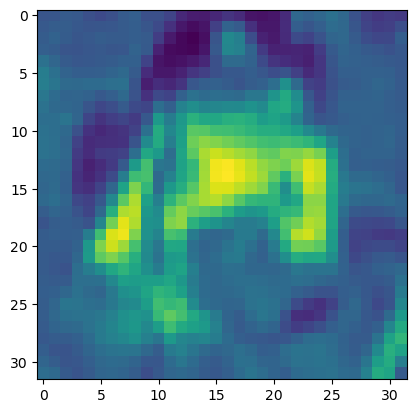

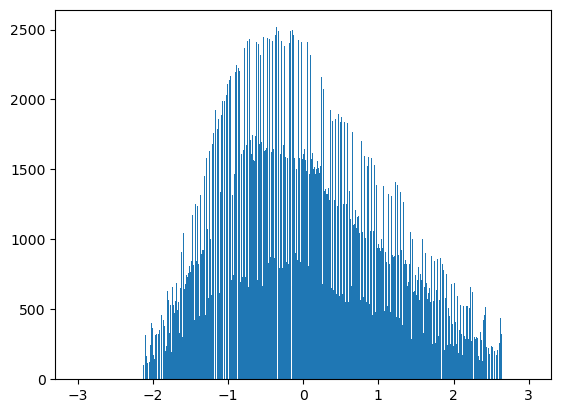

  0%|          | 0/391 [00:00<?, ?it/s]


building model...
training model...
epoch 0


391it [00:10, 37.96it/s]


epoch 1


391it [00:10, 38.54it/s]


epoch 2


391it [00:10, 38.41it/s]


epoch 3


391it [00:10, 37.96it/s]


epoch 4


391it [00:10, 37.90it/s]


epoch 5


391it [00:10, 38.12it/s]


epoch 6


391it [00:09, 39.41it/s]


epoch 7


391it [00:09, 39.65it/s]


epoch 8


391it [00:10, 38.56it/s]


epoch 9


391it [00:10, 38.52it/s]


epoch 10


391it [00:09, 39.13it/s]


epoch 11


391it [00:10, 38.78it/s]


epoch 12


391it [00:10, 38.90it/s]


epoch 13


391it [00:10, 38.00it/s]


epoch 14


391it [00:10, 38.52it/s]


epoch 15


391it [00:10, 38.14it/s]


epoch 16


391it [00:09, 39.27it/s]


epoch 17


391it [00:10, 38.41it/s]


epoch 18


391it [00:10, 38.89it/s]


epoch 19


391it [00:10, 38.76it/s]


epoch 20


391it [00:10, 38.70it/s]


epoch 21


391it [00:09, 39.48it/s]


epoch 22


391it [00:09, 40.12it/s]


epoch 23


391it [00:09, 39.81it/s]


epoch 24


391it [00:10, 38.62it/s]


epoch 25


391it [00:09, 40.05it/s]


epoch 26


391it [00:09, 39.96it/s]


epoch 27


391it [00:09, 39.29it/s]


epoch 28


391it [00:09, 39.58it/s]


epoch 29


391it [00:09, 40.54it/s]


epoch 30


391it [00:09, 40.20it/s]


epoch 31


391it [00:09, 39.68it/s]



Test set: Avg. loss: 0.0052, Accuracy: 40127/50000 (80%)


Test set: Avg. loss: 0.0076, Accuracy: 7416/10000 (74%)

epoch 32


391it [00:09, 39.67it/s]


epoch 33


391it [00:09, 40.09it/s]


epoch 34


391it [00:09, 39.81it/s]


epoch 35


391it [00:10, 38.31it/s]


epoch 36


391it [00:10, 38.08it/s]


epoch 37


391it [00:10, 38.86it/s]


epoch 38


391it [00:09, 39.39it/s]


epoch 39


391it [00:09, 40.81it/s]



Test set: Avg. loss: 0.0051, Accuracy: 40990/50000 (82%)


Test set: Avg. loss: 0.0080, Accuracy: 7419/10000 (74%)

epoch 40


391it [00:09, 39.85it/s]


epoch 41


391it [00:09, 39.83it/s]


epoch 42


391it [00:09, 40.67it/s]


epoch 43


391it [00:09, 39.29it/s]


epoch 44


391it [00:10, 38.95it/s]


epoch 45


391it [00:10, 38.69it/s]


epoch 46


391it [00:09, 39.47it/s]


epoch 47


391it [00:09, 40.14it/s]



Test set: Avg. loss: 0.0051, Accuracy: 41230/50000 (82%)


Test set: Avg. loss: 0.0085, Accuracy: 7421/10000 (74%)

epoch 48


391it [00:09, 39.99it/s]


epoch 49


391it [00:09, 39.67it/s]


epoch 50


391it [00:09, 40.64it/s]


epoch 51


391it [00:09, 40.48it/s]


epoch 52


391it [00:09, 40.05it/s]


epoch 53


391it [00:09, 40.45it/s]


epoch 54


391it [00:09, 39.84it/s]


epoch 55


391it [00:10, 38.96it/s]



Test set: Avg. loss: 0.0048, Accuracy: 42035/50000 (84%)


Test set: Avg. loss: 0.0085, Accuracy: 7542/10000 (75%)

epoch 56


391it [00:10, 38.69it/s]


epoch 57


391it [00:09, 39.21it/s]


epoch 58


391it [00:09, 39.15it/s]


epoch 59


391it [00:10, 38.15it/s]


epoch 60


391it [00:10, 38.80it/s]


epoch 61


391it [00:09, 39.51it/s]


epoch 62


391it [00:10, 39.09it/s]


epoch 63


391it [00:09, 39.71it/s]



Test set: Avg. loss: 0.0050, Accuracy: 42168/50000 (84%)


Test set: Avg. loss: 0.0089, Accuracy: 7506/10000 (75%)

epoch 64


391it [00:09, 39.56it/s]


epoch 65


391it [00:09, 39.36it/s]


epoch 66


391it [00:09, 39.59it/s]


epoch 67


391it [00:09, 39.69it/s]


epoch 68


391it [00:09, 39.34it/s]


epoch 69


391it [00:09, 39.85it/s]


epoch 70


391it [00:09, 39.31it/s]


epoch 71


391it [00:10, 38.89it/s]



Test set: Avg. loss: 0.0043, Accuracy: 42491/50000 (85%)


Test set: Avg. loss: 0.0079, Accuracy: 7554/10000 (76%)

epoch 72


391it [00:09, 40.18it/s]


epoch 73


391it [00:09, 39.59it/s]


epoch 74


391it [00:09, 39.80it/s]


epoch 75


391it [00:10, 39.05it/s]


epoch 76


391it [00:10, 38.47it/s]


epoch 77


391it [00:10, 38.19it/s]


epoch 78


391it [00:10, 38.33it/s]


epoch 79


391it [00:10, 38.30it/s]



Test set: Avg. loss: 0.0047, Accuracy: 42846/50000 (86%)


Test set: Avg. loss: 0.0093, Accuracy: 7557/10000 (76%)

epoch 80


391it [00:09, 39.24it/s]


epoch 81


391it [00:09, 39.45it/s]


epoch 82


391it [00:10, 38.85it/s]


epoch 83


391it [00:09, 39.41it/s]


epoch 84


391it [00:09, 39.38it/s]


epoch 85


391it [00:09, 39.46it/s]


epoch 86


391it [00:09, 39.17it/s]


epoch 87


391it [00:09, 40.02it/s]



Test set: Avg. loss: 0.0050, Accuracy: 42742/50000 (85%)


Test set: Avg. loss: 0.0096, Accuracy: 7533/10000 (75%)

epoch 88


391it [00:09, 39.62it/s]


epoch 89


391it [00:09, 40.60it/s]


epoch 90


391it [00:09, 42.40it/s]


epoch 91


391it [00:10, 38.72it/s]


epoch 92


391it [00:09, 40.01it/s]


epoch 93


391it [00:09, 39.26it/s]


epoch 94


391it [00:10, 38.56it/s]


epoch 95


391it [00:09, 39.14it/s]



Test set: Avg. loss: 0.0049, Accuracy: 43052/50000 (86%)


Test set: Avg. loss: 0.0102, Accuracy: 7471/10000 (75%)

epoch 96


391it [00:09, 39.24it/s]


epoch 97


391it [00:10, 39.00it/s]


epoch 98


391it [00:10, 39.04it/s]


epoch 99


391it [00:09, 39.66it/s]


epoch 100


391it [00:09, 39.62it/s]


epoch 101


391it [00:09, 39.29it/s]


epoch 102


391it [00:09, 39.21it/s]


epoch 103


391it [00:09, 39.41it/s]



Test set: Avg. loss: 0.0048, Accuracy: 43327/50000 (87%)


Test set: Avg. loss: 0.0101, Accuracy: 7563/10000 (76%)

epoch 104


391it [00:09, 39.22it/s]


epoch 105


391it [00:10, 38.50it/s]


epoch 106


391it [00:09, 39.48it/s]


epoch 107


391it [00:10, 39.07it/s]


epoch 108


391it [00:10, 38.94it/s]


epoch 109


391it [00:09, 40.03it/s]


epoch 110


391it [00:09, 39.29it/s]


epoch 111


391it [00:10, 38.47it/s]



Test set: Avg. loss: 0.0048, Accuracy: 43280/50000 (87%)


Test set: Avg. loss: 0.0098, Accuracy: 7559/10000 (76%)

epoch 112


391it [00:10, 39.00it/s]


epoch 113


391it [00:10, 39.07it/s]


epoch 114


391it [00:09, 40.26it/s]


epoch 115


391it [00:09, 39.21it/s]


epoch 116


391it [00:09, 39.78it/s]


epoch 117


391it [00:09, 39.39it/s]


epoch 118


391it [00:09, 39.30it/s]


epoch 119


391it [00:09, 39.12it/s]



Test set: Avg. loss: 0.0048, Accuracy: 43399/50000 (87%)


Test set: Avg. loss: 0.0102, Accuracy: 7583/10000 (76%)

epoch 120


391it [00:09, 39.81it/s]


epoch 121


391it [00:09, 39.57it/s]


epoch 122


391it [00:10, 38.69it/s]


epoch 123


391it [00:09, 39.62it/s]


epoch 124


391it [00:09, 40.15it/s]


epoch 125


391it [00:09, 40.21it/s]


epoch 126


391it [00:09, 40.20it/s]


epoch 127


391it [00:09, 40.00it/s]



Test set: Avg. loss: 0.0047, Accuracy: 43691/50000 (87%)


Test set: Avg. loss: 0.0099, Accuracy: 7651/10000 (77%)

epoch 128


391it [00:10, 38.55it/s]


epoch 129


391it [00:10, 38.50it/s]


epoch 130


391it [00:09, 39.27it/s]


epoch 131


391it [00:09, 40.58it/s]


epoch 132


391it [00:09, 40.06it/s]


epoch 133


391it [00:09, 39.93it/s]


epoch 134


391it [00:09, 40.00it/s]


epoch 135


391it [00:09, 39.53it/s]



Test set: Avg. loss: 0.0048, Accuracy: 43675/50000 (87%)


Test set: Avg. loss: 0.0106, Accuracy: 7611/10000 (76%)

epoch 136


391it [00:10, 39.03it/s]


epoch 137


391it [00:09, 39.11it/s]


epoch 138


391it [00:09, 39.10it/s]


epoch 139


391it [00:10, 38.93it/s]


epoch 140


391it [00:10, 38.75it/s]


epoch 141


391it [00:10, 39.07it/s]


epoch 142


391it [00:10, 38.95it/s]


epoch 143


391it [00:09, 39.41it/s]



Test set: Avg. loss: 0.0048, Accuracy: 43827/50000 (88%)


Test set: Avg. loss: 0.0109, Accuracy: 7586/10000 (76%)

epoch 144


391it [00:09, 39.94it/s]


epoch 145


391it [00:09, 40.02it/s]


epoch 146


391it [00:10, 37.99it/s]


epoch 147


391it [00:10, 38.25it/s]


epoch 148


391it [00:10, 39.01it/s]


epoch 149


391it [00:09, 39.49it/s]


epoch 150


391it [00:09, 39.79it/s]


epoch 151


391it [00:09, 40.38it/s]



Test set: Avg. loss: 0.0049, Accuracy: 43861/50000 (88%)


Test set: Avg. loss: 0.0110, Accuracy: 7624/10000 (76%)

epoch 152


391it [00:09, 39.54it/s]


epoch 153


391it [00:09, 39.53it/s]


epoch 154


391it [00:09, 39.40it/s]


epoch 155


391it [00:09, 39.47it/s]


epoch 156


391it [00:09, 39.34it/s]


epoch 157


391it [00:09, 39.37it/s]


epoch 158


391it [00:10, 38.96it/s]


epoch 159


391it [00:09, 39.30it/s]



Test set: Avg. loss: 0.0048, Accuracy: 43980/50000 (88%)


Test set: Avg. loss: 0.0110, Accuracy: 7650/10000 (76%)

epoch 160


391it [00:09, 39.22it/s]


epoch 161


391it [00:10, 38.60it/s]


epoch 162


391it [00:09, 39.33it/s]


epoch 163


391it [00:09, 39.50it/s]


epoch 164


391it [00:10, 38.86it/s]


epoch 165


391it [00:10, 38.69it/s]


epoch 166


391it [00:10, 38.79it/s]


epoch 167


391it [00:10, 38.91it/s]



Test set: Avg. loss: 0.0050, Accuracy: 44042/50000 (88%)


Test set: Avg. loss: 0.0113, Accuracy: 7617/10000 (76%)

epoch 168


391it [00:09, 39.58it/s]


epoch 169


391it [00:09, 39.81it/s]


epoch 170


391it [00:09, 40.28it/s]


epoch 171


391it [00:09, 40.30it/s]


epoch 172


391it [00:09, 39.48it/s]


epoch 173


391it [00:09, 39.99it/s]


epoch 174


391it [00:09, 39.50it/s]


epoch 175


391it [00:09, 39.16it/s]



Test set: Avg. loss: 0.0048, Accuracy: 44006/50000 (88%)


Test set: Avg. loss: 0.0112, Accuracy: 7658/10000 (77%)

epoch 176


391it [00:10, 38.90it/s]


epoch 177


391it [00:10, 38.57it/s]


epoch 178


391it [00:10, 38.87it/s]


epoch 179


391it [00:10, 38.97it/s]


epoch 180


391it [00:10, 38.45it/s]


epoch 181


391it [00:10, 39.07it/s]


epoch 182


391it [00:09, 39.16it/s]


epoch 183


391it [00:09, 39.53it/s]



Test set: Avg. loss: 0.0049, Accuracy: 44223/50000 (88%)


Test set: Avg. loss: 0.0114, Accuracy: 7671/10000 (77%)

epoch 184


391it [00:09, 39.74it/s]


epoch 185


391it [00:09, 40.75it/s]


epoch 186


391it [00:10, 39.08it/s]


epoch 187


391it [00:09, 39.50it/s]


epoch 188


391it [00:09, 39.28it/s]


epoch 189


391it [00:09, 39.19it/s]


epoch 190


391it [00:09, 39.46it/s]


epoch 191


391it [00:09, 39.71it/s]



Test set: Avg. loss: 0.0051, Accuracy: 44123/50000 (88%)


Test set: Avg. loss: 0.0118, Accuracy: 7660/10000 (77%)

epoch 192


391it [00:09, 39.46it/s]


epoch 193


391it [00:10, 38.94it/s]


epoch 194


391it [00:09, 39.84it/s]


epoch 195


391it [00:09, 39.80it/s]


epoch 196


391it [00:10, 38.94it/s]


epoch 197


391it [00:10, 39.02it/s]


epoch 198


391it [00:10, 38.83it/s]


epoch 199


391it [00:09, 39.27it/s]



Test set: Avg. loss: 0.0050, Accuracy: 44251/50000 (89%)


Test set: Avg. loss: 0.0116, Accuracy: 7675/10000 (77%)

epoch 200


391it [00:09, 39.64it/s]


epoch 201


391it [00:10, 39.01it/s]


epoch 202


391it [00:09, 39.25it/s]


epoch 203


391it [00:10, 38.87it/s]


epoch 204


391it [00:10, 38.73it/s]


epoch 205


391it [00:09, 39.16it/s]


epoch 206


391it [00:10, 38.83it/s]


epoch 207


391it [00:09, 39.13it/s]



Test set: Avg. loss: 0.0050, Accuracy: 44304/50000 (89%)


Test set: Avg. loss: 0.0117, Accuracy: 7672/10000 (77%)

epoch 208


391it [00:10, 38.90it/s]


epoch 209


391it [00:10, 38.92it/s]


epoch 210


391it [00:10, 38.99it/s]


epoch 211


391it [00:09, 39.51it/s]


epoch 212


391it [00:09, 39.16it/s]


epoch 213


391it [00:10, 38.95it/s]


epoch 214


391it [00:09, 39.25it/s]


epoch 215


391it [00:10, 38.77it/s]



Test set: Avg. loss: 0.0050, Accuracy: 44265/50000 (89%)


Test set: Avg. loss: 0.0118, Accuracy: 7696/10000 (77%)

epoch 216


391it [00:10, 38.30it/s]


epoch 217


391it [00:10, 38.76it/s]


epoch 218


391it [00:09, 40.12it/s]


epoch 219


391it [00:09, 40.13it/s]


epoch 220


391it [00:09, 39.33it/s]


epoch 221


391it [00:10, 39.07it/s]


epoch 222


391it [00:09, 39.33it/s]


epoch 223


391it [00:10, 38.92it/s]



Test set: Avg. loss: 0.0050, Accuracy: 44364/50000 (89%)


Test set: Avg. loss: 0.0117, Accuracy: 7697/10000 (77%)

epoch 224


391it [00:10, 38.75it/s]


epoch 225


391it [00:10, 38.89it/s]


epoch 226


391it [00:10, 39.02it/s]


epoch 227


391it [00:10, 38.96it/s]


epoch 228


391it [00:09, 39.10it/s]


epoch 229


391it [00:10, 38.90it/s]


epoch 230


391it [00:10, 38.29it/s]


epoch 231


391it [00:10, 38.35it/s]



Test set: Avg. loss: 0.0050, Accuracy: 44375/50000 (89%)


Test set: Avg. loss: 0.0118, Accuracy: 7689/10000 (77%)

epoch 232


391it [00:09, 40.33it/s]


epoch 233


391it [00:09, 40.06it/s]


epoch 234


391it [00:09, 39.42it/s]


epoch 235


391it [00:09, 39.26it/s]


epoch 236


391it [00:10, 38.94it/s]


epoch 237


391it [00:09, 40.48it/s]


epoch 238


391it [00:09, 39.49it/s]


epoch 239


391it [00:09, 39.99it/s]



Test set: Avg. loss: 0.0051, Accuracy: 44317/50000 (89%)


Test set: Avg. loss: 0.0118, Accuracy: 7693/10000 (77%)



In [9]:
from shearletNN.deit import deit_small_patch16_LS


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((patch_size, patch_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((patch_size, patch_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=False, num_workers=0
)


val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)


for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        # 2 * shearlets.shape[0] * 3,
        3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.float32, x.dtype
    print(x.real.mean((0, 2, 3)))

    print(x.real.std((0, 2, 3)))

    print(x.real.max())

    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    plt.hist(x.flatten().real.cpu().numpy(), bins=501, range=[-3, 3])
    plt.show()
    break
print("building model...")

# 61% with the spatial frequency components
# model = deit_small_patch16_LS(img_size=patch_size, in_chans=2 * shearlets.shape[0] * 3)
model = torchvision.models.resnet18()

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [10]:
class FourierConvolution(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.weight = torch.nn.Parameter(input_size)


class FourierCNN(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        input_dim = 1

        for i in input_size:
            input_dim *= i

        layers = torch.nn.ModuleList([
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            ])



In [11]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_rope_mixed_ape_deit_small_patch4_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size)))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_rope_mixed_ape_deit_small_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

tensor([-0.4054, -0.4069, -0.4116, -0.2797, -0.2768, -0.2761, -0.2773, -0.2810,
         0.4117,  0.4070, -0.4749, -0.4761, -0.4802, -0.1281, -0.1275, -0.1273,
        -0.1278, -0.1292,  0.4802,  0.4761,  0.1807,  0.1832,  0.1893,  0.4303,
         0.4230,  0.4208,  0.4232,  0.4306, -0.1873, -0.1820], device='cuda:0')
tensor([-0.0130, -0.0127, -0.0121, -2.9253, -2.8995, -2.8906, -2.8991, -2.9248,
         0.0138,  0.0133,  0.0219,  0.0230,  0.0247, -4.4512, -4.4134, -4.4005,
        -4.4131, -4.4508, -0.0208, -0.0210,  0.0262,  0.0269,  0.0285, -6.1694,
        -6.1166, -6.0985, -6.1163, -6.1688, -0.0263, -0.0263], device='cuda:0')
tensor([1.5639, 1.5636, 1.5624, 1.5386, 1.5408, 1.5416, 1.5410, 1.5391, 1.5623,
        1.5635, 1.5831, 1.5828, 1.5817, 1.5514, 1.5536, 1.5544, 1.5538, 1.5518,
        1.5814, 1.5827, 1.5557, 1.5554, 1.5543, 1.5101, 1.5121, 1.5129, 1.5123,
        1.5104, 1.5539, 1.5552], device='cuda:0')
tensor([1.5639, 1.5636, 1.5624, 1.5386, 1.5408, 1.5416, 1.5410, 1.5391

training model...
epoch 0


55it [00:06,  8.53it/s]


epoch 1


55it [00:06,  8.62it/s]


epoch 2


55it [00:06,  8.47it/s]


epoch 3


55it [00:06,  8.65it/s]



Test set: Avg. loss: 0.0319, Accuracy: 1320/6941 (19%)


Test set: Avg. loss: 0.0351, Accuracy: 254/1736 (15%)

epoch 4


55it [00:06,  8.67it/s]


epoch 5


55it [00:06,  8.58it/s]


epoch 6


55it [00:06,  8.68it/s]


epoch 7


55it [00:06,  8.62it/s]



Test set: Avg. loss: 0.0279, Accuracy: 1728/6941 (25%)


Test set: Avg. loss: 0.0330, Accuracy: 297/1736 (17%)

epoch 8


55it [00:06,  8.65it/s]


epoch 9


55it [00:06,  8.58it/s]


epoch 10


55it [00:06,  8.65it/s]


epoch 11


55it [00:06,  8.57it/s]



Test set: Avg. loss: 0.0257, Accuracy: 1963/6941 (28%)


Test set: Avg. loss: 0.0316, Accuracy: 353/1736 (20%)

epoch 12


55it [00:06,  8.66it/s]


epoch 13


55it [00:06,  8.50it/s]


epoch 14


55it [00:06,  8.55it/s]


epoch 15


55it [00:06,  8.38it/s]



Test set: Avg. loss: 0.0242, Accuracy: 2144/6941 (31%)


Test set: Avg. loss: 0.0310, Accuracy: 339/1736 (20%)

epoch 16


55it [00:06,  8.56it/s]


epoch 17


55it [00:06,  8.37it/s]


epoch 18


55it [00:06,  8.61it/s]


epoch 19


55it [00:06,  8.48it/s]



Test set: Avg. loss: 0.0232, Accuracy: 2368/6941 (34%)


Test set: Avg. loss: 0.0303, Accuracy: 380/1736 (22%)

epoch 20


55it [00:06,  8.34it/s]


epoch 21


55it [00:06,  8.38it/s]


epoch 22


55it [00:06,  8.43it/s]


epoch 23


55it [00:06,  8.35it/s]



Test set: Avg. loss: 0.0218, Accuracy: 2514/6941 (36%)


Test set: Avg. loss: 0.0272, Accuracy: 458/1736 (26%)

epoch 24


55it [00:06,  8.39it/s]


epoch 25


55it [00:06,  8.29it/s]


epoch 26


55it [00:06,  8.27it/s]


epoch 27


55it [00:06,  8.13it/s]



Test set: Avg. loss: 0.0202, Accuracy: 2682/6941 (39%)


Test set: Avg. loss: 0.0271, Accuracy: 478/1736 (28%)

epoch 28


55it [00:06,  8.46it/s]


epoch 29


55it [00:06,  8.39it/s]


epoch 30


55it [00:06,  8.29it/s]


epoch 31


55it [00:06,  8.44it/s]



Test set: Avg. loss: 0.0194, Accuracy: 2854/6941 (41%)


Test set: Avg. loss: 0.0265, Accuracy: 521/1736 (30%)

epoch 32


55it [00:06,  8.54it/s]


epoch 33


55it [00:06,  8.33it/s]


epoch 34


55it [00:06,  8.29it/s]


epoch 35


55it [00:06,  8.28it/s]



Test set: Avg. loss: 0.0186, Accuracy: 3003/6941 (43%)


Test set: Avg. loss: 0.0258, Accuracy: 507/1736 (29%)

epoch 36


55it [00:06,  8.40it/s]


epoch 37


55it [00:06,  8.27it/s]


epoch 38


55it [00:06,  8.37it/s]


epoch 39


55it [00:06,  8.43it/s]



Test set: Avg. loss: 0.0174, Accuracy: 3192/6941 (46%)


Test set: Avg. loss: 0.0257, Accuracy: 545/1736 (31%)

epoch 40


55it [00:06,  8.46it/s]


epoch 41


55it [00:06,  8.35it/s]


epoch 42


55it [00:06,  8.46it/s]


epoch 43


55it [00:06,  8.34it/s]



Test set: Avg. loss: 0.0174, Accuracy: 3199/6941 (46%)


Test set: Avg. loss: 0.0239, Accuracy: 582/1736 (34%)

epoch 44


55it [00:06,  8.04it/s]


epoch 45


55it [00:06,  8.05it/s]


epoch 46


55it [00:06,  8.40it/s]


epoch 47


55it [00:06,  8.38it/s]



Test set: Avg. loss: 0.0160, Accuracy: 3448/6941 (50%)


Test set: Avg. loss: 0.0245, Accuracy: 583/1736 (34%)

epoch 48


55it [00:06,  8.50it/s]


epoch 49


55it [00:06,  8.52it/s]


epoch 50


55it [00:06,  8.32it/s]


epoch 51


55it [00:06,  8.26it/s]



Test set: Avg. loss: 0.0159, Accuracy: 3462/6941 (50%)


Test set: Avg. loss: 0.0237, Accuracy: 632/1736 (36%)

epoch 52


55it [00:06,  8.44it/s]


epoch 53


55it [00:06,  8.30it/s]


epoch 54


55it [00:06,  8.45it/s]


epoch 55


55it [00:06,  8.44it/s]



Test set: Avg. loss: 0.0155, Accuracy: 3535/6941 (51%)


Test set: Avg. loss: 0.0241, Accuracy: 606/1736 (35%)

epoch 56


55it [00:06,  8.39it/s]


epoch 57


55it [00:06,  8.29it/s]


epoch 58


55it [00:06,  8.20it/s]


epoch 59


55it [00:06,  8.23it/s]



Test set: Avg. loss: 0.0150, Accuracy: 3623/6941 (52%)


Test set: Avg. loss: 0.0240, Accuracy: 621/1736 (36%)

epoch 60


55it [00:06,  8.39it/s]


epoch 61


55it [00:06,  8.29it/s]


epoch 62


55it [00:06,  8.35it/s]


epoch 63


55it [00:06,  8.41it/s]



Test set: Avg. loss: 0.0139, Accuracy: 3827/6941 (55%)


Test set: Avg. loss: 0.0231, Accuracy: 643/1736 (37%)

epoch 64


55it [00:06,  8.50it/s]


epoch 65


55it [00:06,  8.52it/s]


epoch 66


55it [00:06,  8.35it/s]


epoch 67


55it [00:06,  8.64it/s]



Test set: Avg. loss: 0.0135, Accuracy: 3830/6941 (55%)


Test set: Avg. loss: 0.0228, Accuracy: 638/1736 (37%)

epoch 68


55it [00:06,  8.60it/s]


epoch 69


55it [00:06,  8.58it/s]


epoch 70


55it [00:06,  8.52it/s]


epoch 71


55it [00:06,  8.60it/s]



Test set: Avg. loss: 0.0133, Accuracy: 3942/6941 (57%)


Test set: Avg. loss: 0.0235, Accuracy: 653/1736 (38%)

epoch 72


55it [00:06,  8.57it/s]


epoch 73


55it [00:06,  8.41it/s]


epoch 74


55it [00:06,  8.57it/s]


epoch 75


55it [00:06,  8.49it/s]



Test set: Avg. loss: 0.0127, Accuracy: 4068/6941 (59%)


Test set: Avg. loss: 0.0223, Accuracy: 672/1736 (39%)

epoch 76


55it [00:06,  8.52it/s]


epoch 77


55it [00:06,  8.50it/s]


epoch 78


55it [00:06,  8.51it/s]


epoch 79


55it [00:06,  8.42it/s]



Test set: Avg. loss: 0.0119, Accuracy: 4186/6941 (60%)


Test set: Avg. loss: 0.0230, Accuracy: 691/1736 (40%)

epoch 80


55it [00:06,  8.67it/s]


epoch 81


55it [00:06,  8.47it/s]


epoch 82


55it [00:06,  8.60it/s]


epoch 83


55it [00:06,  8.51it/s]



Test set: Avg. loss: 0.0121, Accuracy: 4198/6941 (60%)


Test set: Avg. loss: 0.0224, Accuracy: 689/1736 (40%)

epoch 84


55it [00:06,  8.51it/s]


epoch 85


55it [00:06,  8.47it/s]


epoch 86


55it [00:06,  8.57it/s]


epoch 87


55it [00:06,  8.45it/s]



Test set: Avg. loss: 0.0116, Accuracy: 4262/6941 (61%)


Test set: Avg. loss: 0.0219, Accuracy: 731/1736 (42%)

epoch 88


55it [00:06,  8.61it/s]


epoch 89


55it [00:06,  8.49it/s]


epoch 90


55it [00:06,  8.55it/s]


epoch 91


55it [00:06,  8.42it/s]



Test set: Avg. loss: 0.0114, Accuracy: 4268/6941 (61%)


Test set: Avg. loss: 0.0218, Accuracy: 747/1736 (43%)

epoch 92


55it [00:06,  8.44it/s]


epoch 93


55it [00:06,  8.48it/s]


epoch 94


55it [00:06,  8.53it/s]


epoch 95


55it [00:06,  8.48it/s]



Test set: Avg. loss: 0.0106, Accuracy: 4472/6941 (64%)


Test set: Avg. loss: 0.0211, Accuracy: 717/1736 (41%)

epoch 96


55it [00:06,  8.51it/s]


epoch 97


55it [00:06,  8.22it/s]


epoch 98


55it [00:06,  8.40it/s]


epoch 99


55it [00:06,  8.32it/s]



Test set: Avg. loss: 0.0104, Accuracy: 4497/6941 (65%)


Test set: Avg. loss: 0.0222, Accuracy: 692/1736 (40%)

epoch 100


55it [00:06,  8.45it/s]


epoch 101


55it [00:06,  8.27it/s]


epoch 102


55it [00:06,  8.41it/s]


epoch 103


55it [00:06,  8.07it/s]



Test set: Avg. loss: 0.0099, Accuracy: 4608/6941 (66%)


Test set: Avg. loss: 0.0216, Accuracy: 718/1736 (41%)

epoch 104


55it [00:06,  8.40it/s]


epoch 105


55it [00:06,  8.52it/s]


epoch 106


55it [00:06,  8.50it/s]


epoch 107


55it [00:06,  8.49it/s]



Test set: Avg. loss: 0.0095, Accuracy: 4701/6941 (68%)


Test set: Avg. loss: 0.0219, Accuracy: 765/1736 (44%)

epoch 108


55it [00:06,  8.48it/s]


epoch 109


55it [00:06,  8.47it/s]


epoch 110


55it [00:06,  8.49it/s]


epoch 111


55it [00:06,  8.26it/s]



Test set: Avg. loss: 0.0092, Accuracy: 4793/6941 (69%)


Test set: Avg. loss: 0.0220, Accuracy: 721/1736 (42%)

epoch 112


55it [00:06,  8.37it/s]


epoch 113


55it [00:06,  8.27it/s]


epoch 114


55it [00:06,  8.37it/s]


epoch 115


55it [00:06,  8.27it/s]



Test set: Avg. loss: 0.0090, Accuracy: 4788/6941 (69%)


Test set: Avg. loss: 0.0221, Accuracy: 759/1736 (44%)

epoch 116


55it [00:06,  8.30it/s]


epoch 117


55it [00:06,  8.27it/s]


epoch 118


55it [00:06,  8.35it/s]


epoch 119


55it [00:06,  8.32it/s]



Test set: Avg. loss: 0.0091, Accuracy: 4797/6941 (69%)


Test set: Avg. loss: 0.0223, Accuracy: 734/1736 (42%)

epoch 120


55it [00:06,  8.30it/s]


epoch 121


55it [00:06,  8.28it/s]


epoch 122


55it [00:06,  8.29it/s]


epoch 123


55it [00:06,  8.31it/s]



Test set: Avg. loss: 0.0084, Accuracy: 4941/6941 (71%)


Test set: Avg. loss: 0.0227, Accuracy: 759/1736 (44%)

epoch 124


55it [00:06,  8.31it/s]


epoch 125


55it [00:06,  8.41it/s]


epoch 126


55it [00:06,  8.61it/s]


epoch 127


55it [00:06,  8.50it/s]



Test set: Avg. loss: 0.0080, Accuracy: 5042/6941 (73%)


Test set: Avg. loss: 0.0221, Accuracy: 785/1736 (45%)

epoch 128


55it [00:06,  8.32it/s]


epoch 129


55it [00:06,  8.21it/s]


epoch 130


55it [00:06,  8.06it/s]


epoch 131


55it [00:06,  8.26it/s]



Test set: Avg. loss: 0.0080, Accuracy: 5001/6941 (72%)


Test set: Avg. loss: 0.0220, Accuracy: 785/1736 (45%)

epoch 132


55it [00:06,  8.32it/s]


epoch 133


55it [00:06,  8.30it/s]


epoch 134


55it [00:06,  8.23it/s]


epoch 135


55it [00:06,  8.10it/s]



Test set: Avg. loss: 0.0079, Accuracy: 5028/6941 (72%)


Test set: Avg. loss: 0.0224, Accuracy: 756/1736 (44%)

epoch 136


55it [00:06,  8.30it/s]


epoch 137


55it [00:06,  8.02it/s]


epoch 138


55it [00:06,  8.42it/s]


epoch 139


55it [00:06,  8.30it/s]



Test set: Avg. loss: 0.0076, Accuracy: 5144/6941 (74%)


Test set: Avg. loss: 0.0222, Accuracy: 775/1736 (45%)

epoch 140


55it [00:06,  8.23it/s]


epoch 141


55it [00:06,  8.20it/s]


epoch 142


55it [00:06,  8.33it/s]


epoch 143


55it [00:06,  8.24it/s]



Test set: Avg. loss: 0.0071, Accuracy: 5213/6941 (75%)


Test set: Avg. loss: 0.0215, Accuracy: 787/1736 (45%)

epoch 144


55it [00:06,  8.18it/s]


epoch 145


55it [00:06,  8.26it/s]


epoch 146


55it [00:06,  8.28it/s]


epoch 147


55it [00:06,  8.76it/s]



Test set: Avg. loss: 0.0072, Accuracy: 5183/6941 (75%)


Test set: Avg. loss: 0.0229, Accuracy: 762/1736 (44%)

epoch 148


55it [00:06,  8.46it/s]


epoch 149


55it [00:06,  8.51it/s]


epoch 150


55it [00:06,  8.66it/s]


epoch 151


55it [00:06,  8.56it/s]



Test set: Avg. loss: 0.0071, Accuracy: 5195/6941 (75%)


Test set: Avg. loss: 0.0221, Accuracy: 816/1736 (47%)

epoch 152


55it [00:06,  8.57it/s]


epoch 153


55it [00:06,  8.64it/s]


epoch 154


55it [00:06,  8.66it/s]


epoch 155


55it [00:06,  8.61it/s]



Test set: Avg. loss: 0.0063, Accuracy: 5360/6941 (77%)


Test set: Avg. loss: 0.0232, Accuracy: 811/1736 (47%)

epoch 156


55it [00:06,  8.52it/s]


epoch 157


55it [00:06,  8.65it/s]


epoch 158


55it [00:06,  8.66it/s]


epoch 159


55it [00:06,  8.58it/s]



Test set: Avg. loss: 0.0063, Accuracy: 5402/6941 (78%)


Test set: Avg. loss: 0.0230, Accuracy: 783/1736 (45%)

epoch 160


55it [00:06,  8.60it/s]


epoch 161


55it [00:06,  8.75it/s]


epoch 162


55it [00:06,  8.75it/s]


epoch 163


55it [00:06,  8.65it/s]



Test set: Avg. loss: 0.0062, Accuracy: 5377/6941 (77%)


Test set: Avg. loss: 0.0245, Accuracy: 805/1736 (46%)

epoch 164


55it [00:06,  8.63it/s]


epoch 165


55it [00:06,  8.65it/s]


epoch 166


55it [00:06,  8.67it/s]


epoch 167


55it [00:06,  8.73it/s]



Test set: Avg. loss: 0.0061, Accuracy: 5455/6941 (79%)


Test set: Avg. loss: 0.0232, Accuracy: 843/1736 (49%)

epoch 168


55it [00:06,  8.66it/s]


epoch 169


55it [00:06,  8.67it/s]


epoch 170


55it [00:06,  8.74it/s]


epoch 171


55it [00:06,  8.65it/s]



Test set: Avg. loss: 0.0059, Accuracy: 5485/6941 (79%)


Test set: Avg. loss: 0.0242, Accuracy: 794/1736 (46%)

epoch 172


55it [00:06,  8.78it/s]


epoch 173


55it [00:06,  8.72it/s]


epoch 174


55it [00:06,  8.68it/s]


epoch 175


55it [00:06,  8.65it/s]



Test set: Avg. loss: 0.0056, Accuracy: 5568/6941 (80%)


Test set: Avg. loss: 0.0233, Accuracy: 835/1736 (48%)

epoch 176


55it [00:06,  8.21it/s]


epoch 177


55it [00:06,  8.26it/s]


epoch 178


55it [00:06,  8.63it/s]


epoch 179


55it [00:06,  8.66it/s]



Test set: Avg. loss: 0.0056, Accuracy: 5511/6941 (79%)


Test set: Avg. loss: 0.0237, Accuracy: 833/1736 (48%)

epoch 180


55it [00:06,  8.60it/s]


epoch 181


55it [00:06,  8.65it/s]


epoch 182


55it [00:06,  8.76it/s]


epoch 183


55it [00:06,  8.75it/s]



Test set: Avg. loss: 0.0053, Accuracy: 5589/6941 (81%)


Test set: Avg. loss: 0.0242, Accuracy: 833/1736 (48%)

epoch 184


55it [00:06,  8.82it/s]


epoch 185


55it [00:06,  8.73it/s]


epoch 186


55it [00:06,  8.74it/s]


epoch 187


55it [00:06,  8.76it/s]



Test set: Avg. loss: 0.0053, Accuracy: 5634/6941 (81%)


Test set: Avg. loss: 0.0235, Accuracy: 834/1736 (48%)

epoch 188


55it [00:06,  8.74it/s]


epoch 189


55it [00:06,  8.67it/s]


epoch 190


55it [00:06,  8.85it/s]


epoch 191


55it [00:06,  8.66it/s]



Test set: Avg. loss: 0.0054, Accuracy: 5625/6941 (81%)


Test set: Avg. loss: 0.0235, Accuracy: 844/1736 (49%)

epoch 192


55it [00:06,  8.71it/s]


epoch 193


55it [00:06,  8.80it/s]


epoch 194


55it [00:06,  8.74it/s]


epoch 195


55it [00:06,  8.80it/s]



Test set: Avg. loss: 0.0052, Accuracy: 5627/6941 (81%)


Test set: Avg. loss: 0.0244, Accuracy: 854/1736 (49%)

epoch 196


55it [00:06,  8.71it/s]


epoch 197


55it [00:06,  8.70it/s]


epoch 198


55it [00:06,  8.81it/s]


epoch 199


55it [00:06,  8.67it/s]



Test set: Avg. loss: 0.0051, Accuracy: 5653/6941 (81%)


Test set: Avg. loss: 0.0242, Accuracy: 851/1736 (49%)

epoch 200


55it [00:06,  8.76it/s]


epoch 201


55it [00:06,  8.61it/s]


epoch 202


55it [00:06,  8.68it/s]


epoch 203


55it [00:06,  8.75it/s]



Test set: Avg. loss: 0.0050, Accuracy: 5675/6941 (82%)


Test set: Avg. loss: 0.0245, Accuracy: 831/1736 (48%)

epoch 204


55it [00:06,  8.63it/s]


epoch 205


55it [00:06,  8.69it/s]


epoch 206


55it [00:06,  8.79it/s]


epoch 207


55it [00:06,  8.74it/s]



Test set: Avg. loss: 0.0050, Accuracy: 5697/6941 (82%)


Test set: Avg. loss: 0.0243, Accuracy: 866/1736 (50%)

epoch 208


55it [00:06,  8.81it/s]


epoch 209


55it [00:06,  8.75it/s]


epoch 210


55it [00:06,  8.74it/s]


epoch 211


55it [00:06,  8.81it/s]



Test set: Avg. loss: 0.0050, Accuracy: 5686/6941 (82%)


Test set: Avg. loss: 0.0241, Accuracy: 852/1736 (49%)

epoch 212


55it [00:06,  8.81it/s]


epoch 213


55it [00:06,  8.75it/s]


epoch 214


55it [00:06,  8.78it/s]


epoch 215


55it [00:06,  8.83it/s]



Test set: Avg. loss: 0.0049, Accuracy: 5726/6941 (82%)


Test set: Avg. loss: 0.0244, Accuracy: 862/1736 (50%)

epoch 216


55it [00:06,  8.80it/s]


epoch 217


55it [00:06,  8.65it/s]


epoch 218


55it [00:06,  8.76it/s]


epoch 219


55it [00:06,  8.78it/s]



Test set: Avg. loss: 0.0046, Accuracy: 5749/6941 (83%)


Test set: Avg. loss: 0.0245, Accuracy: 869/1736 (50%)

epoch 220


55it [00:06,  8.83it/s]


epoch 221


55it [00:06,  8.80it/s]


epoch 222


55it [00:06,  8.77it/s]


epoch 223


55it [00:06,  8.75it/s]



Test set: Avg. loss: 0.0048, Accuracy: 5712/6941 (82%)


Test set: Avg. loss: 0.0246, Accuracy: 864/1736 (50%)

epoch 224


55it [00:06,  8.74it/s]


epoch 225


55it [00:06,  8.68it/s]


epoch 226


55it [00:06,  8.69it/s]


epoch 227


55it [00:06,  8.82it/s]



Test set: Avg. loss: 0.0048, Accuracy: 5753/6941 (83%)


Test set: Avg. loss: 0.0245, Accuracy: 866/1736 (50%)

epoch 228


55it [00:06,  8.73it/s]


epoch 229


55it [00:06,  8.70it/s]


epoch 230


55it [00:06,  8.80it/s]


epoch 231


55it [00:06,  8.70it/s]



Test set: Avg. loss: 0.0046, Accuracy: 5792/6941 (83%)


Test set: Avg. loss: 0.0244, Accuracy: 860/1736 (50%)

epoch 232


55it [00:06,  8.58it/s]


epoch 233


55it [00:06,  8.71it/s]


epoch 234


55it [00:06,  8.69it/s]


epoch 235


55it [00:06,  8.69it/s]



Test set: Avg. loss: 0.0046, Accuracy: 5785/6941 (83%)


Test set: Avg. loss: 0.0244, Accuracy: 861/1736 (50%)

epoch 236


55it [00:06,  8.79it/s]


epoch 237


55it [00:06,  8.74it/s]


epoch 238


55it [00:06,  8.66it/s]


epoch 239


55it [00:06,  8.86it/s]



Test set: Avg. loss: 0.0049, Accuracy: 5726/6941 (82%)


Test set: Avg. loss: 0.0244, Accuracy: 863/1736 (50%)



In [12]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(complex_symlog(shifted_spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size))))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_freakformer_tiny_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

with torch.no_grad():
    for param in model.parameters():
        if not ((param == 0).all() or (param == 1).all()):
            param.data /= 2 ** (0.5)
        if param.is_complex():
            param.data = param.data.type(torch.complex64)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

tensor([-0.4085, -0.4100, -0.4145, -0.2794, -0.2764, -0.2758, -0.2771, -0.2808,
         0.4133,  0.4085, -0.4751, -0.4763, -0.4803, -0.1275, -0.1269, -0.1263,
        -0.1269, -0.1283,  0.4797,  0.4756,  0.1822,  0.1847,  0.1908,  0.4319,
         0.4245,  0.4230,  0.4254,  0.4327, -0.1885, -0.1833], device='cuda:0')
tensor([-0.0144, -0.0141, -0.0135, -2.9239, -2.8982, -2.8893, -2.8978, -2.9234,
         0.0130,  0.0125,  0.0199,  0.0209,  0.0227, -4.4517, -4.4140, -4.4001,
        -4.4129, -4.4506, -0.0206, -0.0209,  0.0246,  0.0254,  0.0270, -6.1730,
        -6.1201, -6.1011, -6.1189, -6.1715, -0.0259, -0.0259], device='cuda:0')
tensor([0.3920, 0.3946, 0.4020, 0.3877, 0.3814, 0.3784, 0.3806, 0.3873, 0.4024,
        0.3953, 0.3903, 0.3929, 0.4002, 0.3854, 0.3792, 0.3761, 0.3782, 0.3849,
        0.4006, 0.3936, 0.3936, 0.3962, 0.4037, 0.3835, 0.3772, 0.3742, 0.3765,
        0.3831, 0.4042, 0.3971], device='cuda:0')
tensor([0.3920, 0.3946, 0.4020, 0.3877, 0.3814, 0.3784, 0.3806, 0.3873

NameError: name 'complex_freakformer_tiny_patch4_LS' is not defined

In [ ]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(complex_symlog(shifted_spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size))))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_Lfreakformer_tiny_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

with torch.no_grad():
    for param in model.parameters():
        if not ((param == 0).all() or (param == 1).all()):
            param.data /= 2 ** (0.5)
        if param.is_complex():
            param.data = param.data.type(torch.complex64)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]


tensor([-0.0539, -0.0652, -0.0580,  1.5405,  1.5376,  1.4870,  1.5346,  1.5402,
         0.0546,  0.0474, -0.0831, -0.1000, -0.0895,  2.1363,  2.1297,  2.0741,
         2.1282,  2.1360,  0.0867,  0.0762, -0.0625, -0.0809, -0.0681,  3.3890,
         3.3770,  3.2945,  3.3745,  3.3885,  0.0657,  0.0523], device='cuda:0')
tensor([-0.2771, -0.2887, -0.2948, -0.8925, -0.8923, -0.8496, -0.8926, -0.8926,
         0.2950,  0.2885,  0.1269,  0.1275,  0.1198, -1.4393, -1.4370, -1.3791,
        -1.4364, -1.4390, -0.1193, -0.1253,  4.6624,  4.6809,  4.6969, -6.8812,
        -6.8530, -6.7729, -6.8539, -6.8812, -4.6967, -4.6806], device='cuda:0')
tensor([1.0104, 1.0105, 1.0104, 1.0021, 1.0021, 1.0021, 1.0020, 1.0021, 1.0104,
        1.0104, 1.0161, 1.0162, 1.0161, 1.0182, 1.0182, 1.0183, 1.0182, 1.0182,
        1.0161, 1.0161, 1.0213, 1.0214, 1.0213, 1.0216, 1.0217, 1.0218, 1.0217,
        1.0216, 1.0213, 1.0213], device='cuda:0')
tensor([1.0104, 1.0105, 1.0104, 1.0021, 1.0021, 1.0021, 1.0020, 1.0021

391it [00:21, 18.13it/s]


epoch 1


391it [00:21, 18.10it/s]


epoch 2


391it [00:21, 18.44it/s]


epoch 3


391it [00:20, 18.82it/s]



Test set: Avg. loss: 0.0172, Accuracy: 7342/50000 (15%)


Test set: Avg. loss: 0.0174, Accuracy: 1443/10000 (14%)

epoch 4


391it [00:21, 18.42it/s]


epoch 5


391it [00:21, 17.80it/s]


epoch 6


391it [00:22, 17.76it/s]


epoch 7


391it [00:21, 17.93it/s]



Test set: Avg. loss: 0.0163, Accuracy: 10441/50000 (21%)


Test set: Avg. loss: 0.0164, Accuracy: 2110/10000 (21%)

epoch 8


391it [00:21, 18.18it/s]


epoch 9


391it [00:21, 18.19it/s]


epoch 10


391it [00:21, 18.35it/s]


epoch 11


391it [00:21, 18.39it/s]



Test set: Avg. loss: 0.0153, Accuracy: 13543/50000 (27%)


Test set: Avg. loss: 0.0152, Accuracy: 2769/10000 (28%)

epoch 12


391it [00:21, 18.28it/s]


epoch 13


391it [00:21, 18.44it/s]


epoch 14


391it [00:21, 18.00it/s]


epoch 15


391it [00:21, 18.01it/s]



Test set: Avg. loss: 0.0145, Accuracy: 15948/50000 (32%)


Test set: Avg. loss: 0.0143, Accuracy: 3324/10000 (33%)

epoch 16


391it [00:21, 18.38it/s]


epoch 17


391it [00:21, 18.51it/s]


epoch 18


391it [00:21, 17.92it/s]


epoch 19


391it [00:21, 18.50it/s]



Test set: Avg. loss: 0.0133, Accuracy: 19194/50000 (38%)


Test set: Avg. loss: 0.0132, Accuracy: 4016/10000 (40%)

epoch 20


391it [00:21, 18.48it/s]


epoch 21


391it [00:20, 18.84it/s]


epoch 22


391it [00:20, 19.03it/s]


epoch 23


391it [00:21, 18.52it/s]



Test set: Avg. loss: 0.0127, Accuracy: 21100/50000 (42%)


Test set: Avg. loss: 0.0125, Accuracy: 4366/10000 (44%)

epoch 24


391it [00:22, 17.70it/s]


epoch 25


391it [00:21, 18.13it/s]


epoch 26


391it [00:20, 19.34it/s]


epoch 27


391it [00:20, 19.39it/s]



Test set: Avg. loss: 0.0123, Accuracy: 21818/50000 (44%)


Test set: Avg. loss: 0.0121, Accuracy: 4492/10000 (45%)

epoch 28


391it [00:19, 19.58it/s]


epoch 29


391it [00:19, 19.56it/s]


epoch 30


391it [00:19, 19.78it/s]


epoch 31


391it [00:20, 18.64it/s]



Test set: Avg. loss: 0.0117, Accuracy: 23612/50000 (47%)


Test set: Avg. loss: 0.0115, Accuracy: 4843/10000 (48%)

epoch 32


391it [00:20, 19.26it/s]


epoch 33


391it [00:20, 18.85it/s]


epoch 34


391it [00:19, 19.87it/s]


epoch 35


391it [00:19, 19.69it/s]



Test set: Avg. loss: 0.0110, Accuracy: 24970/50000 (50%)


Test set: Avg. loss: 0.0111, Accuracy: 5022/10000 (50%)

epoch 36


391it [00:20, 19.28it/s]


epoch 37


391it [00:20, 18.83it/s]


epoch 38


391it [00:21, 18.04it/s]


epoch 39


391it [00:21, 18.19it/s]



Test set: Avg. loss: 0.0108, Accuracy: 25696/50000 (51%)


Test set: Avg. loss: 0.0107, Accuracy: 5220/10000 (52%)

epoch 40


391it [00:21, 18.48it/s]


epoch 41


391it [00:21, 18.12it/s]


epoch 42


391it [00:20, 19.19it/s]


epoch 43


391it [00:20, 19.16it/s]



Test set: Avg. loss: 0.0105, Accuracy: 25942/50000 (52%)


Test set: Avg. loss: 0.0107, Accuracy: 5216/10000 (52%)

epoch 44


391it [00:20, 19.34it/s]


epoch 45


391it [00:20, 19.13it/s]


epoch 46


391it [00:20, 19.51it/s]


epoch 47


391it [00:20, 19.51it/s]



Test set: Avg. loss: 0.0101, Accuracy: 26999/50000 (54%)


Test set: Avg. loss: 0.0104, Accuracy: 5415/10000 (54%)

epoch 48


391it [00:20, 18.97it/s]


epoch 49


391it [00:21, 18.13it/s]


epoch 50


391it [00:21, 18.36it/s]


epoch 51


391it [00:21, 18.19it/s]



Test set: Avg. loss: 0.0098, Accuracy: 28120/50000 (56%)


Test set: Avg. loss: 0.0100, Accuracy: 5541/10000 (55%)

epoch 52


391it [00:21, 17.78it/s]


epoch 53


391it [00:21, 18.08it/s]


epoch 54


391it [00:21, 18.31it/s]


epoch 55


391it [00:21, 18.42it/s]



Test set: Avg. loss: 0.0096, Accuracy: 28556/50000 (57%)


Test set: Avg. loss: 0.0100, Accuracy: 5614/10000 (56%)

epoch 56


391it [00:20, 18.85it/s]


epoch 57


391it [00:21, 18.06it/s]


epoch 58


391it [00:20, 18.80it/s]


epoch 59


391it [00:22, 17.62it/s]



Test set: Avg. loss: 0.0090, Accuracy: 29757/50000 (60%)


Test set: Avg. loss: 0.0096, Accuracy: 5726/10000 (57%)

epoch 60


391it [00:20, 18.65it/s]


epoch 61


391it [00:21, 18.48it/s]


epoch 62


391it [00:21, 17.94it/s]


epoch 63


391it [00:21, 18.42it/s]



Test set: Avg. loss: 0.0089, Accuracy: 30003/50000 (60%)


Test set: Avg. loss: 0.0098, Accuracy: 5674/10000 (57%)

epoch 64


391it [00:21, 18.38it/s]


epoch 65


391it [00:21, 18.46it/s]


epoch 66


391it [00:20, 19.21it/s]


epoch 67


391it [00:20, 18.85it/s]



Test set: Avg. loss: 0.0088, Accuracy: 30409/50000 (61%)


Test set: Avg. loss: 0.0097, Accuracy: 5744/10000 (57%)

epoch 68


391it [00:21, 18.61it/s]


epoch 69


391it [00:20, 18.94it/s]


epoch 70


391it [00:21, 18.18it/s]


epoch 71


391it [00:20, 19.02it/s]



Test set: Avg. loss: 0.0082, Accuracy: 31687/50000 (63%)


Test set: Avg. loss: 0.0094, Accuracy: 5849/10000 (58%)

epoch 72


391it [00:20, 19.09it/s]


epoch 73


391it [00:21, 18.61it/s]


epoch 74


391it [00:21, 18.46it/s]


epoch 75


391it [00:20, 18.82it/s]



Test set: Avg. loss: 0.0079, Accuracy: 32345/50000 (65%)


Test set: Avg. loss: 0.0093, Accuracy: 5989/10000 (60%)

epoch 76


391it [00:21, 18.53it/s]


epoch 77


391it [00:20, 18.74it/s]


epoch 78


391it [00:20, 19.03it/s]


epoch 79


391it [00:20, 18.77it/s]



Test set: Avg. loss: 0.0075, Accuracy: 33051/50000 (66%)


Test set: Avg. loss: 0.0092, Accuracy: 6026/10000 (60%)

epoch 80


391it [00:20, 18.65it/s]


epoch 81


391it [00:20, 19.06it/s]


epoch 82


391it [00:21, 18.26it/s]


epoch 83


391it [00:21, 17.77it/s]



Test set: Avg. loss: 0.0073, Accuracy: 33635/50000 (67%)


Test set: Avg. loss: 0.0091, Accuracy: 6037/10000 (60%)

epoch 84


391it [00:21, 18.22it/s]


epoch 85


391it [00:22, 17.60it/s]


epoch 86


391it [00:21, 18.57it/s]


epoch 87


391it [00:21, 17.99it/s]



Test set: Avg. loss: 0.0071, Accuracy: 34070/50000 (68%)


Test set: Avg. loss: 0.0091, Accuracy: 6075/10000 (61%)

epoch 88


391it [00:21, 18.45it/s]


epoch 89


391it [00:21, 17.87it/s]


epoch 90


391it [00:21, 18.14it/s]


epoch 91


391it [00:21, 18.59it/s]



Test set: Avg. loss: 0.0069, Accuracy: 34669/50000 (69%)


Test set: Avg. loss: 0.0090, Accuracy: 6067/10000 (61%)

epoch 92


391it [00:21, 18.26it/s]


epoch 93


391it [00:21, 18.42it/s]


epoch 94


391it [00:20, 18.85it/s]


epoch 95


391it [00:21, 18.43it/s]



Test set: Avg. loss: 0.0065, Accuracy: 35584/50000 (71%)


Test set: Avg. loss: 0.0091, Accuracy: 6176/10000 (62%)

epoch 96


391it [00:21, 18.29it/s]


epoch 97


391it [00:21, 17.99it/s]


epoch 98


391it [00:20, 18.78it/s]


epoch 99


391it [00:21, 18.47it/s]



Test set: Avg. loss: 0.0061, Accuracy: 36452/50000 (73%)


Test set: Avg. loss: 0.0090, Accuracy: 6163/10000 (62%)

epoch 100


391it [00:21, 18.26it/s]


epoch 101


391it [00:21, 18.49it/s]


epoch 102


391it [00:21, 18.44it/s]


epoch 103


391it [00:20, 19.05it/s]



Test set: Avg. loss: 0.0060, Accuracy: 36829/50000 (74%)


Test set: Avg. loss: 0.0091, Accuracy: 6163/10000 (62%)

epoch 104


391it [00:20, 19.45it/s]


epoch 105


391it [00:20, 19.25it/s]


epoch 106


391it [00:20, 18.73it/s]


epoch 107


391it [00:20, 18.80it/s]



Test set: Avg. loss: 0.0058, Accuracy: 36992/50000 (74%)


Test set: Avg. loss: 0.0091, Accuracy: 6235/10000 (62%)

epoch 108


391it [00:20, 18.99it/s]


epoch 109


391it [00:20, 19.19it/s]


epoch 110


391it [00:20, 18.91it/s]


epoch 111


391it [00:20, 19.00it/s]



Test set: Avg. loss: 0.0055, Accuracy: 37845/50000 (76%)


Test set: Avg. loss: 0.0093, Accuracy: 6257/10000 (63%)

epoch 112


391it [00:20, 18.83it/s]


epoch 113


391it [00:20, 19.01it/s]


epoch 114


391it [00:21, 18.53it/s]


epoch 115


391it [00:21, 18.38it/s]



Test set: Avg. loss: 0.0054, Accuracy: 38126/50000 (76%)


Test set: Avg. loss: 0.0093, Accuracy: 6214/10000 (62%)

epoch 116


391it [00:21, 18.53it/s]


epoch 117


391it [00:21, 18.28it/s]


epoch 118


391it [00:20, 18.88it/s]


epoch 119


391it [00:20, 18.68it/s]



Test set: Avg. loss: 0.0052, Accuracy: 38470/50000 (77%)


Test set: Avg. loss: 0.0093, Accuracy: 6244/10000 (62%)

epoch 120


391it [00:20, 18.98it/s]


epoch 121


391it [00:20, 19.12it/s]


epoch 122


391it [00:20, 19.24it/s]


epoch 123


391it [00:21, 18.21it/s]



Test set: Avg. loss: 0.0050, Accuracy: 38917/50000 (78%)


Test set: Avg. loss: 0.0093, Accuracy: 6243/10000 (62%)

epoch 124


391it [00:21, 17.80it/s]


epoch 125


391it [00:21, 18.23it/s]


epoch 126


391it [00:22, 17.50it/s]


epoch 127


391it [00:21, 18.04it/s]



Test set: Avg. loss: 0.0047, Accuracy: 39634/50000 (79%)


Test set: Avg. loss: 0.0094, Accuracy: 6302/10000 (63%)

epoch 128


391it [00:21, 18.46it/s]


epoch 129


391it [00:21, 18.15it/s]


epoch 130


391it [00:21, 18.04it/s]


epoch 131


391it [00:22, 17.67it/s]



Test set: Avg. loss: 0.0046, Accuracy: 39964/50000 (80%)


Test set: Avg. loss: 0.0096, Accuracy: 6259/10000 (63%)

epoch 132


391it [00:20, 18.80it/s]


epoch 133


391it [00:21, 18.46it/s]


epoch 134


391it [00:21, 18.19it/s]


epoch 135


391it [00:21, 17.92it/s]



Test set: Avg. loss: 0.0046, Accuracy: 40010/50000 (80%)


Test set: Avg. loss: 0.0101, Accuracy: 6194/10000 (62%)

epoch 136


391it [00:21, 18.28it/s]


epoch 137


391it [00:21, 18.16it/s]


epoch 138


391it [00:21, 18.56it/s]


epoch 139


391it [00:21, 17.97it/s]



Test set: Avg. loss: 0.0043, Accuracy: 40752/50000 (82%)


Test set: Avg. loss: 0.0099, Accuracy: 6251/10000 (63%)

epoch 140


391it [00:21, 18.11it/s]


epoch 141


391it [00:21, 18.18it/s]


epoch 142


391it [00:21, 17.95it/s]


epoch 143


391it [00:20, 18.70it/s]



Test set: Avg. loss: 0.0041, Accuracy: 41088/50000 (82%)


Test set: Avg. loss: 0.0103, Accuracy: 6239/10000 (62%)

epoch 144


391it [00:20, 18.64it/s]


epoch 145


391it [00:19, 19.66it/s]


epoch 146


391it [00:20, 19.45it/s]


epoch 147


391it [00:20, 19.08it/s]



Test set: Avg. loss: 0.0039, Accuracy: 41459/50000 (83%)


Test set: Avg. loss: 0.0101, Accuracy: 6312/10000 (63%)

epoch 148


391it [00:20, 19.28it/s]


epoch 149


391it [00:20, 19.55it/s]


epoch 150


391it [00:20, 19.14it/s]


epoch 151


391it [00:20, 18.84it/s]



Test set: Avg. loss: 0.0038, Accuracy: 41862/50000 (84%)


Test set: Avg. loss: 0.0102, Accuracy: 6297/10000 (63%)

epoch 152


391it [00:20, 18.84it/s]


epoch 153


391it [00:21, 18.43it/s]


epoch 154


391it [00:21, 18.33it/s]


epoch 155


391it [00:21, 18.31it/s]



Test set: Avg. loss: 0.0036, Accuracy: 42182/50000 (84%)


Test set: Avg. loss: 0.0103, Accuracy: 6272/10000 (63%)

epoch 156


391it [00:21, 18.27it/s]


epoch 157


391it [00:25, 15.42it/s]


epoch 158


391it [00:23, 16.86it/s]


epoch 159


391it [00:22, 17.71it/s]



Test set: Avg. loss: 0.0034, Accuracy: 42566/50000 (85%)


Test set: Avg. loss: 0.0104, Accuracy: 6329/10000 (63%)

epoch 160


391it [00:20, 18.95it/s]


epoch 161


391it [00:21, 17.89it/s]


epoch 162


391it [00:20, 18.62it/s]


epoch 163


391it [00:21, 18.27it/s]



Test set: Avg. loss: 0.0034, Accuracy: 42734/50000 (85%)


Test set: Avg. loss: 0.0109, Accuracy: 6277/10000 (63%)

epoch 164


391it [00:21, 18.34it/s]


epoch 165


391it [00:21, 18.21it/s]


epoch 166


391it [00:21, 18.14it/s]


epoch 167


391it [00:21, 18.24it/s]



Test set: Avg. loss: 0.0033, Accuracy: 42967/50000 (86%)


Test set: Avg. loss: 0.0110, Accuracy: 6257/10000 (63%)

epoch 168


391it [00:23, 16.98it/s]


epoch 169


391it [00:21, 17.99it/s]


epoch 170


391it [00:22, 17.65it/s]


epoch 171


391it [00:22, 17.42it/s]



Test set: Avg. loss: 0.0031, Accuracy: 43361/50000 (87%)


Test set: Avg. loss: 0.0107, Accuracy: 6345/10000 (63%)

epoch 172


391it [00:21, 18.08it/s]


epoch 173


391it [00:22, 17.26it/s]


epoch 174


391it [00:23, 16.97it/s]


epoch 175


391it [00:22, 17.47it/s]



Test set: Avg. loss: 0.0030, Accuracy: 43556/50000 (87%)


Test set: Avg. loss: 0.0111, Accuracy: 6328/10000 (63%)

epoch 176


391it [00:21, 17.97it/s]


epoch 177


391it [00:22, 17.29it/s]


epoch 178


391it [00:22, 17.45it/s]


epoch 179


391it [00:23, 16.67it/s]



Test set: Avg. loss: 0.0029, Accuracy: 43891/50000 (88%)


Test set: Avg. loss: 0.0113, Accuracy: 6274/10000 (63%)

epoch 180


391it [00:23, 16.44it/s]


epoch 181


391it [00:22, 17.24it/s]


epoch 182


391it [00:23, 16.79it/s]


epoch 183


391it [00:22, 17.72it/s]



Test set: Avg. loss: 0.0028, Accuracy: 43915/50000 (88%)


Test set: Avg. loss: 0.0111, Accuracy: 6305/10000 (63%)

epoch 184


391it [00:22, 17.11it/s]


epoch 185


391it [00:22, 17.18it/s]


epoch 186


391it [00:22, 17.29it/s]


epoch 187


391it [00:22, 17.54it/s]



Test set: Avg. loss: 0.0027, Accuracy: 44204/50000 (88%)


Test set: Avg. loss: 0.0112, Accuracy: 6316/10000 (63%)

epoch 188


391it [00:22, 17.18it/s]


epoch 189


391it [00:23, 16.79it/s]


epoch 190


391it [00:22, 17.63it/s]


epoch 191


391it [00:22, 17.46it/s]



Test set: Avg. loss: 0.0027, Accuracy: 44194/50000 (88%)


Test set: Avg. loss: 0.0113, Accuracy: 6331/10000 (63%)

epoch 192


391it [00:24, 15.82it/s]


epoch 193


391it [00:23, 16.57it/s]


epoch 194


391it [00:21, 18.15it/s]


epoch 195


391it [00:21, 17.95it/s]



Test set: Avg. loss: 0.0026, Accuracy: 44508/50000 (89%)


Test set: Avg. loss: 0.0115, Accuracy: 6314/10000 (63%)

epoch 196


391it [00:21, 18.06it/s]


epoch 197


391it [00:20, 18.89it/s]


epoch 198


391it [00:20, 18.98it/s]


epoch 199


391it [00:21, 18.58it/s]



Test set: Avg. loss: 0.0025, Accuracy: 44734/50000 (89%)


Test set: Avg. loss: 0.0116, Accuracy: 6322/10000 (63%)

epoch 200


391it [00:22, 17.73it/s]


epoch 201


391it [00:21, 18.33it/s]


epoch 202


391it [00:22, 17.61it/s]


epoch 203


391it [00:22, 17.54it/s]



Test set: Avg. loss: 0.0025, Accuracy: 44776/50000 (90%)


Test set: Avg. loss: 0.0115, Accuracy: 6358/10000 (64%)

epoch 204


391it [00:22, 17.53it/s]


epoch 205


391it [00:22, 17.32it/s]


epoch 206


391it [00:22, 17.23it/s]


epoch 207


391it [00:22, 17.20it/s]



Test set: Avg. loss: 0.0024, Accuracy: 44888/50000 (90%)


Test set: Avg. loss: 0.0118, Accuracy: 6336/10000 (63%)

epoch 208


391it [00:22, 17.16it/s]


epoch 209


391it [00:23, 16.44it/s]


epoch 210


391it [00:22, 17.24it/s]


epoch 211


391it [00:23, 16.44it/s]



Test set: Avg. loss: 0.0024, Accuracy: 44989/50000 (90%)


Test set: Avg. loss: 0.0119, Accuracy: 6302/10000 (63%)

epoch 212


391it [00:22, 17.25it/s]


epoch 213


391it [00:22, 17.25it/s]


epoch 214


391it [00:24, 16.16it/s]


epoch 215


391it [00:23, 16.93it/s]



Test set: Avg. loss: 0.0023, Accuracy: 45174/50000 (90%)


Test set: Avg. loss: 0.0117, Accuracy: 6338/10000 (63%)

epoch 216


391it [00:23, 16.75it/s]


epoch 217


391it [00:24, 15.73it/s]


epoch 218


391it [00:24, 16.28it/s]


epoch 219


391it [00:23, 16.86it/s]



Test set: Avg. loss: 0.0024, Accuracy: 45104/50000 (90%)


Test set: Avg. loss: 0.0120, Accuracy: 6329/10000 (63%)

epoch 220


391it [00:23, 16.71it/s]


epoch 221


391it [00:28, 13.66it/s]


epoch 222


391it [00:22, 17.72it/s]


epoch 223


391it [00:21, 18.42it/s]



Test set: Avg. loss: 0.0023, Accuracy: 45289/50000 (91%)


Test set: Avg. loss: 0.0119, Accuracy: 6329/10000 (63%)

epoch 224


391it [00:21, 18.60it/s]


epoch 225


391it [00:21, 18.21it/s]


epoch 226


391it [00:22, 17.69it/s]


epoch 227


391it [00:23, 17.00it/s]



Test set: Avg. loss: 0.0023, Accuracy: 45123/50000 (90%)


Test set: Avg. loss: 0.0119, Accuracy: 6349/10000 (63%)

epoch 228


391it [00:21, 18.11it/s]


epoch 229


391it [00:21, 18.04it/s]


epoch 230


391it [00:21, 17.96it/s]


epoch 231


391it [00:21, 18.09it/s]



Test set: Avg. loss: 0.0023, Accuracy: 45325/50000 (91%)


Test set: Avg. loss: 0.0119, Accuracy: 6346/10000 (63%)

epoch 232


391it [00:21, 18.26it/s]


epoch 233


391it [00:21, 18.04it/s]


epoch 234


391it [00:21, 18.05it/s]


epoch 235


391it [00:22, 17.58it/s]



Test set: Avg. loss: 0.0023, Accuracy: 45181/50000 (90%)


Test set: Avg. loss: 0.0120, Accuracy: 6331/10000 (63%)

epoch 236


391it [00:22, 17.77it/s]


epoch 237


391it [00:22, 17.75it/s]


epoch 238


391it [00:21, 17.79it/s]


epoch 239


391it [00:21, 18.02it/s]



Test set: Avg. loss: 0.0023, Accuracy: 45171/50000 (90%)


Test set: Avg. loss: 0.0119, Accuracy: 6332/10000 (63%)

